In [ ]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from sklearn.decomposition import PCA
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
data= pd.read_csv(url)
data=data.drop('0',axis=1)
data['g']=data['g'].replace(['b','g'],[0,1])
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('g')
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data[cols2zscore] = data[cols2zscore]/ np.max(data[cols2zscore])

In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['g'].values ).float()
labels = labels[:,None] # transform to matrix

In [ ]:
dataT.shape

torch.Size([350, 33])

# Create the DL model

In [ ]:
# create a class for the model
def createTheRadar(n_enc,n_bottle):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(33,n_enc)
      
      ### encoder layer
      self.enc = nn.Linear(n_enc,n_bottle)

      ### latent layer
      self.lat = nn.Linear(n_bottle,n_enc)

      ### decoder layer
      self.dec = nn.Linear(n_enc,33)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      
      # output the hidden-layer activation
      codex = F.relu( self.enc(x) )
      
      x = F.relu( self.lat(codex) )
      y = torch.sigmoid( self.dec(x) )
      return y,codex
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with a bit of data
net,lossfun,optimizer = createTheRadar(100,10)

X = dataT[:5,:]
yHat = net(X)

print('Input shape:')
print(X.shape)
print(' ')

# yHat is now a tuple
print(type(yHat),len(yHat))
print(' ')

print('Shape of model output:')
print(yHat[0].shape)
print(' ')

print('Shape of encoding layer output:')
print(yHat[1].shape)

Input shape:
torch.Size([5, 33])
 
<class 'tuple'> 2
 
Shape of model output:
torch.Size([5, 33])
 
Shape of encoding layer output:
torch.Size([5, 10])


# Create a function that trains the model

In [ ]:
def function2trainTheModel(n_enc,n_bottle):

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheRadar(n_enc,n_bottle)

  # initialize losses
  losses = []


  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):

    
    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)

    # losses during the batches
    batchlosses = []

    for batchi in range(numBatches):
      
      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)[0]
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      # losses in this batch
      batchlosses.append( loss.item() )
    # end minibatch loop
  
    losses.append( np.mean(batchlosses) )
  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.1182


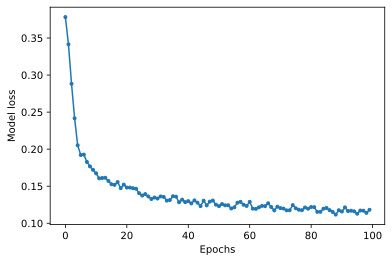

In [ ]:
# train the model
losses,net = function2trainTheModel(280,9)
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Inspect the latent "code" of the model

torch.Size([350, 33])
torch.Size([350, 9])


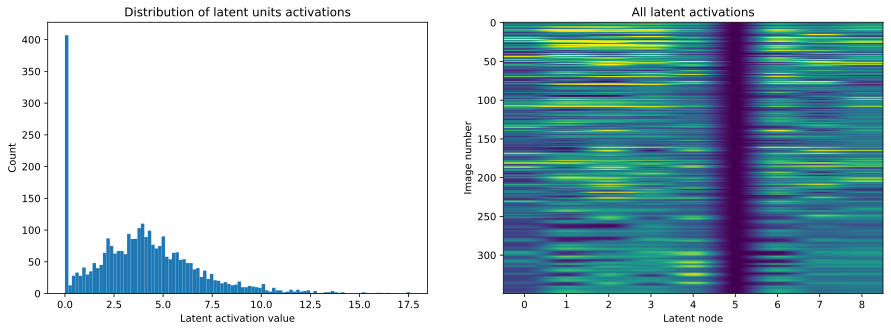

In [ ]:
# output the latent layer

# push through the entire dataset
yHat,latent = net(dataT)

# print sizes
print(yHat.shape)
print(latent.shape)

# what does it look like?
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(latent.flatten().detach(),100)
ax[0].set_xlabel('Latent activation value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of latent units activations')

ax[1].imshow(latent.detach(),aspect='auto',vmin=0,vmax=10)
ax[1].set_xlabel('Latent node')
ax[1].set_ylabel('Image number')
ax[1].set_title('All latent activations')

plt.show()

In [ ]:
digidx = np.where(labels==0)[0]
digidx

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207,
       209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233,
       235, 237, 239, 241, 243, 245, 247, 249, 251])

In [ ]:
latent

tensor([[7.4695, 6.8373, 7.5823,  ..., 6.4604, 4.3043, 7.6158],
        [3.2988, 7.2592, 4.9492,  ..., 5.6543, 3.5936, 4.9245],
        [2.4507, 0.0407, 7.1265,  ..., 5.5933, 3.2655, 3.3573],
        ...,
        [2.1407, 6.4864, 4.9399,  ..., 6.1399, 3.5816, 3.8138],
        [2.6592, 7.1264, 5.6805,  ..., 5.9424, 3.9844, 4.1623],
        [2.0754, 6.2696, 4.7857,  ..., 5.7301, 3.5321, 4.2378]],
       grad_fn=<ReluBackward0>)

In [ ]:
latent[digidx,:]
torch.mean(latent[digidx,:],axis=0)

tensor([4.8201, 4.3880, 6.2949, 4.6174, 3.7630, 0.0000, 5.1169, 4.7905, 4.8762],
       grad_fn=<MeanBackward1>)

In [ ]:
latent.shape[1]

9

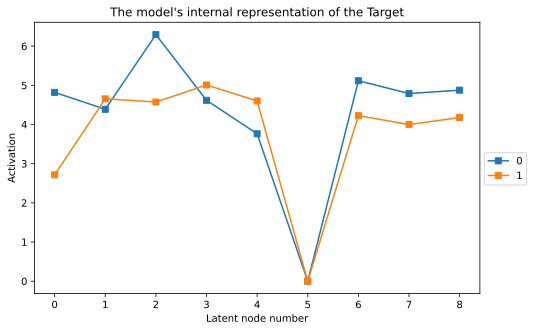

In [ ]:
# compute the average latent activation for each digit type

# initialize output matrix (latent shape by 2 types)
sourcecode = np.zeros((latent.shape[1],2))


# loop over digit categories
for i in range(2):

  # find all pictures of this category
  digidx = np.where(labels==i)[0]

  # average the latent layer output
  sourcecode[:,i] = torch.mean(latent[digidx,:],axis=0).detach()



fig = plt.figure(figsize=(8,5))

plt.plot(sourcecode,'s-')
plt.legend(range(2),loc=(1.01,.4))
plt.xticks(range(9))
plt.xlabel('Latent node number')
plt.ylabel('Activation')
plt.title("The model's internal representation of the Target")
plt.show()

# Explore the reduced-compressed space with PCA

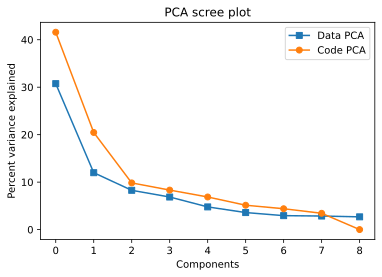

In [ ]:
# compute and fit the PCA
pcaData = PCA(n_components=9).fit(data) 
pcaCode = PCA(               ).fit(latent.detach())


# plot the eigenspectra (scree plot)
plt.plot(100*pcaData.explained_variance_ratio_,'s-',label='Data PCA')
plt.plot(100*pcaCode.explained_variance_ratio_,'o-',label='Code PCA')
plt.xlabel('Components')
plt.ylabel('Percent variance explained')
plt.title('PCA scree plot')
plt.legend()
plt.show()

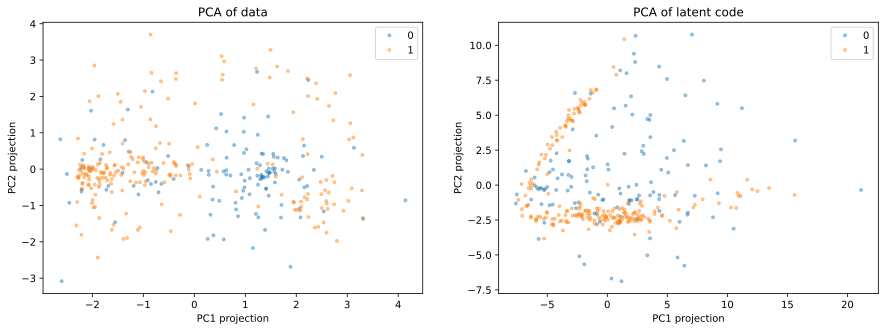

In [ ]:
# compute the projection of the data onto the PC axes
scoresData = pcaData.fit_transform(data)
scoresCode = pcaCode.fit_transform(latent.detach())

# plot the data separately per number
fig,ax = plt.subplots(1,2,figsize=(15,5))

for lab in range(2):
  ax[0].plot(scoresData[np.where(labels==lab)[0],0],scoresData[np.where(labels==lab)[0],1],'o',markersize=3,alpha=.4)
  ax[1].plot(scoresCode[np.where(labels==lab)[0],0],scoresCode[np.where(labels==lab)[0],1],'o',markersize=3,alpha=.4)

for i in range(2):
  ax[i].set_xlabel('PC1 projection')
  ax[i].set_ylabel('PC2 projection')
  ax[i].legend(range(2))

ax[0].set_title('PCA of data')
ax[1].set_title('PCA of latent code')
plt.show()

In [ ]:
latent.shape

torch.Size([350, 9])

In [ ]:
latent

tensor([[7.4695, 6.8373, 7.5823,  ..., 6.4604, 4.3043, 7.6158],
        [3.2988, 7.2592, 4.9492,  ..., 5.6543, 3.5936, 4.9245],
        [2.4507, 0.0407, 7.1265,  ..., 5.5933, 3.2655, 3.3573],
        ...,
        [2.1407, 6.4864, 4.9399,  ..., 6.1399, 3.5816, 3.8138],
        [2.6592, 7.1264, 5.6805,  ..., 5.9424, 3.9844, 4.1623],
        [2.0754, 6.2696, 4.7857,  ..., 5.7301, 3.5321, 4.2378]],
       grad_fn=<ReluBackward0>)

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(latent.detach(), labels, test_size=.1)

# then convert them into PyTorch Datasets 
train_dataDataset_reduct = TensorDataset(train_data,train_labels)
test_dataDataset_reduct  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader_reduct  = DataLoader(test_dataDataset_reduct,batch_size=test_dataDataset_reduct.tensors[0].shape[0])
train_loader_reduct = DataLoader(train_dataDataset_reduct,batch_size=32, shuffle=True, drop_last=True)

In [ ]:
for item in train_loader_reduct:
  print(item[0].shape)

torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])
torch.Size([32, 9])


In [ ]:
class ANNRadar_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(9,16)
    
    ### hidden layers
    self.fc1    = nn.Linear(16,16)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
    self.fc2    = nn.Linear(16,16)
    self.bnorm2 = nn.BatchNorm1d(16) # the number of units into this layer

    ### output layer
    self.output = nn.Linear(16,1)
  
  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )


    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)    # weighted combination
      x = F.relu(x)      # activation function
    

    else:
      # hidden layer 1
      x = F.relu( self.fc1(x) )

      # hidden layer 2
      x = F.relu( self.fc2(x) )

    # output layer
    return self.output(x)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(Radarnet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    Radarnet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader_reduct:

      # forward pass and loss
      yHat = Radarnet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy

    # NOTE: batch normalization should be turned off during testing, so we definitely need to switch modes here
    Radarnet.eval()
    X,y = next(iter(test_loader_reduct)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = Radarnet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [ ]:
# create a model and train it
Radarnet = ANNRadar_withBNorm()
trainByO,testByO,lossesByO = trainTheModel()

In [ ]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [ ]:
trainByO= smooth(trainByO,15)
testByO  = smooth(testByO,15)
lossesByO= smooth(lossesByO,15)

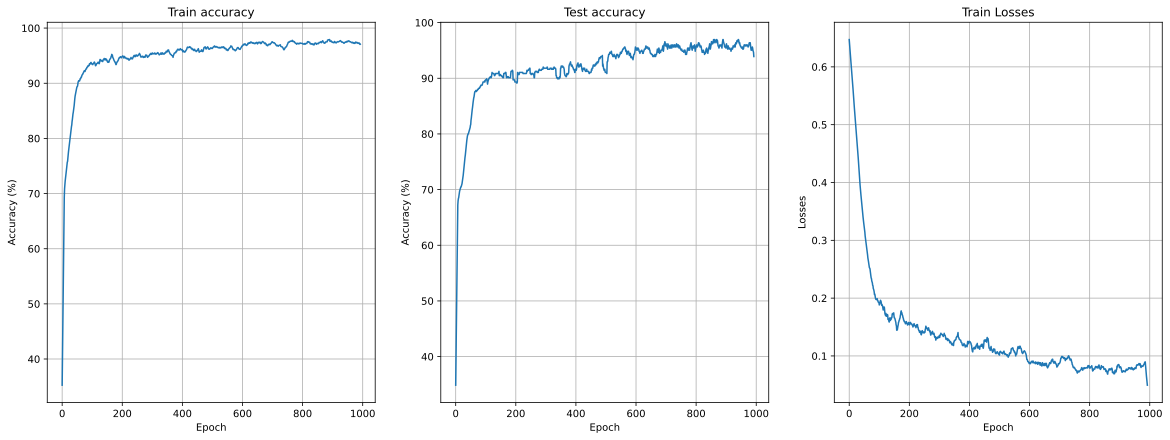

In [ ]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(20,7))

ax[0].plot(trainByO[:993])
ax[0].set_title('Train accuracy')
ax[1].plot(testByO[:993])
ax[1].set_title('Test accuracy')
ax[2].plot(lossesByO[7:])
ax[2].set_title('Train Losses')
# common features
for i in range(2):
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  #ax[i].set_ylim([50,100])
  ax[i].grid()
ax[2].set_xlabel('Epoch')
#ax[2].set_ylim([-0.1,0.5])
ax[2].set_ylabel('Losses')
ax[2].grid()

plt.show()